In [ ]:
!conda install -c conda-forge python-chromedriver-binary

In [1]:
import warnings
warnings.filterwarnings('ignore')

import swifter
import importlib.util
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.compose import make_column_selector as selector, ColumnTransformer, make_column_transformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor


import pandas as pd
import numpy as np
from scipy.stats import skew
import joblib
import altair as alt
from altair_saver import save

import re
import json

In [2]:
parse_times = ["MKOPEN", "MKCLOSE", "MKEMHOPEN", "MKEMHCLOSE",
               "MKOPENYEST", "MKCLOSEYEST", "MKOPENTOM",
               "MKCLOSETOM","EPOPEN", "EPCLOSE", "EPEMHOPEN",
               "EPEMHCLOSE", "EPOPENYEST", "EPCLOSEYEST",
               "EPOPENTOM", "EPCLOSETOM", "HSOPEN", "HSCLOSE",
               "HSEMHOPEN", "HSEMHCLOSE", "HSOPENYEST", "HSCLOSEYEST",
               "HSOPENTOM", "HSCLOSETOM", "AKOPEN", "AKCLOSE",
               "AKEMHOPEN", "AKOPENYEST", "AKCLOSEYEST","AKEMHCLOSE",
               "AKOPENTOM", "AKCLOSETOM", "MKPRDDT1", "MKPRDDT2",
               "MKPRDNT1", "MKPRDNT2", "MKFIRET1", "MKFIRET2",
               "EPFIRET1", "EPFIRET2", "HSPRDDT1", "HSFIRET1",
               "HSFIRET2", "HSSHWNT1", "HSSHWNT2", "AKPRDDT1",
               "AKPRDDT2", "AKSHWNT1", "AKSHWNT2"]

In [3]:
def setup():
    with open("../data/processed/dtypes_parsed.json") as json_file:
        dtypes = json.load(json_file)

    return dtypes


def loadTrainTestPostedWaitTimes():
    """
            Loads train test data for posted wait times

            How to use:

            import importlib.util

            spec = importlib.util.spec_from_file_location("loadTrainTestPostedWaitTimes", "src/data/loadTrainTestData.py")
            loadTrainPosted = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(loadTrainPosted)

            X_train_posted, X_test_posted, y_train_posted, y_test_posted = loadTrainPosted.loadTrainTestPostedWaitTimes()

            Parameters
            ----------

            Returns
            -------
            rideDataDf_trainX - train data features for posted wait times
            rideDataDf_testX - test data features for posted wait times
            rideDataDf_trainY - train data targets for posted wait times
            rideDataDf_testY - test data targets for posted wait times

        """
    parse_dates = ['date', 'datetime']
    X_train_list = []
    y_train_list = []
    dtypes = setup()

    for year in range(2015, 2022):

        rideData = pd.read_csv(f'../data/processed/All_train_postedtimes{year}.csv', dtype=dtypes,
                               parse_dates=parse_dates, compression='gzip')
        rideDataX = rideData.drop(columns=["POSTED_WAIT"])
        rideDataY = rideData["POSTED_WAIT"]
        X_train_list.append(rideDataX)
        y_train_list.append(rideDataY)

    rideDataDf_trainX = pd.concat(X_train_list, ignore_index=True)
    rideDataDf_trainY = pd.concat(y_train_list, ignore_index=True)


    X_test_list = []
    y_test_list = []

    for year in range(2015, 2022):
        rideData = pd.read_csv(f'../data/processed/All_test_postedtimes{year}.csv', dtype=dtypes,
                               parse_dates=parse_dates, compression='gzip')
        rideDataX = rideData.drop(columns=["POSTED_WAIT"])
        rideDataY = rideData["POSTED_WAIT"]

        X_test_list.append(rideDataX)
        y_test_list.append(rideDataY)

    rideDataDf_testX = pd.concat(X_test_list, ignore_index=True)
    rideDataDf_testY = pd.concat(y_test_list, ignore_index=True)

    return rideDataDf_trainX, rideDataDf_testX, rideDataDf_trainY, rideDataDf_testY

In [4]:
X_train, X_test, y_train, y_test = loadTrainTestPostedWaitTimes()

In [5]:
X_train["MONTHOFYEAR"] = X_train["date"].dt.month.astype("Int8")
X_train["YEAR"] = X_train["date"].dt.year.astype("Int16")
X_train["DAYOFYEAR"] = X_train["date"].dt.dayofyear.astype("Int16")
X_train["HOUROFDAY"] = X_train["datetime"].dt.hour.astype("Int8")

X_test["MONTHOFYEAR"] = X_test["date"].dt.month.astype("Int8")
X_test["YEAR"] = X_test["date"].dt.year.astype("Int16")
X_test["DAYOFYEAR"] = X_test["date"].dt.dayofyear.astype("Int16")
X_test["HOUROFDAY"] = X_test["datetime"].dt.hour.astype("Int8")

In [6]:
train = pd.concat([X_train, y_train], axis=1).sort_values(['datetime'])
test = pd.concat([X_test, y_test], axis=1).sort_values(['datetime'])

X_train_impute = train.drop(columns=["POSTED_WAIT"])
y_train = train["POSTED_WAIT"]

X_test_impute = test.drop(columns=["POSTED_WAIT"])
y_test = test["POSTED_WAIT"]

In [7]:
X_train_clean = X_train_impute.drop(columns=['date', 'datetime', 'Unnamed: 0'])
X_test_clean = X_test_impute.drop(columns=['date', 'datetime', 'Unnamed: 0'])

# Pipeline

Helper Function for Imputation & Log Transformation

In [8]:
allCols = list(X_train_clean.columns)

def impute_transform(x):
    for col in x:
        if col in parse_times:
            x[col] = x[col].fillna("99")
            x[col] = x[col].apply(lambda h: h[:2] if h[0] != 0 else h[:1]).astype(int).astype("Int8")

        x[col] = x[col].fillna(method='bfill')
        x[col] = x[col].fillna(x[col].median())

        if (x[col].dtype != "bool") and (abs(skew(list(x[col]))) > 0.8):
            # +20 linear scale on all values to ensure no resulting -inf vals
            x[f"log_{col}"] = x[col].apply(lambda k: np.log(k + 20))

            x.drop(columns=[col], inplace=True)

    return x


In [9]:
preprocessor = make_column_transformer(
      (RobustScaler(), selector(dtype_include=np.number)), remainder='passthrough')


In [10]:
# rf = Pipeline(
#     steps=[("imputerAndLogTransformer", FunctionTransformer(impute_transform)),
#            ("preprocessor", preprocessor), 
#            ("regressor", RandomForestRegressor(n_estimators=10, max_depth=50, n_jobs=-1, random_state=0))]
# )

# rf.fit(X_train_clean, y_train)

# joblib.dump(rf, 'pipeline.pkl' + '.gz', compress=('gzip', 5))

############
#OR
############

rf = joblib.load("pipeline.pkl.gz")

In [11]:
pred = rf.predict(X_test_clean)

In [12]:
mae = metrics.mean_absolute_error(y_test, pred)
mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
r2 = metrics.r2_score(y_test, pred)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R-SQUARED: ", r2)

MAE:  40.45313127097203
MSE:  22577.2899065588
RMSE:  150.25741215180966
R-SQUARED:  0.7326651661948325


-------------------------------

# Regression Results Exploration

## Feature Importance

In [78]:
alt.renderers.enable('png')
feature_importance = pd.Series(rf.steps[2][1].feature_importances_, index=X_train_clean.columns).astype(float)
sorted_importances = feature_importance.sort_values(ascending=False)
top30 = pd.DataFrame(sorted_importances.head(30)).reset_index()
top30.columns = ["feature_name", "importance"]

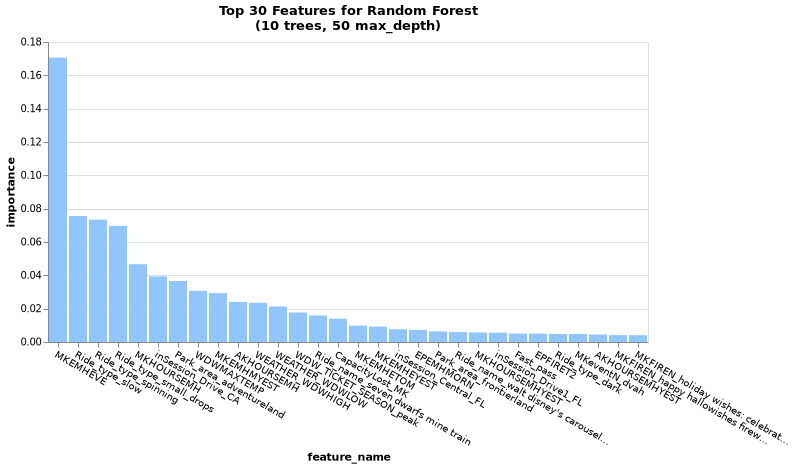

In [79]:
feat_imp = alt.Chart(top30).mark_bar(color="#90C6FA").encode(
    x=alt.X('feature_name', sort='-y', axis=alt.Axis(labelAngle=30)),
    y='importance'
).properties(title=["Top 30 Features for Random Forest", "(10 trees, 50 max_depth)"])
save(feat_imp, "../reports/figures/FinalModelFeatureImportance.png")

feat_imp

## Wait Time Analysis by Ride

Taking an exploratory approach to predicted wait times. 

In this analysis, we are considering a prediction less than 0 minutes to mean the ride is "down" and we calculated probability that the ride is down by taking the number of preditions less than 0 during a given hour vs. all predictions for that hour. We are also only looking at predictions from 2018 or later to narrow in on the trends of the most recent years.

In [72]:
original_features = X_test_impute.drop(columns=['date', 'datetime', 'Unnamed: 0'])
all_test = pd.concat([original_features, pd.Series(pred)], axis = 1).rename(columns={0:"PREDICTED_WAIT"})

class RideResults:
    def __init__(self, rideCol, rideName, results, corrThreshold=0.05):
        self.rideCol = rideCol
        self.rideName = rideName
        self.results = results
        self.corrThreshold = corrThreshold
        
    def visualize_wait_times(self, lower_thresh, upper_thresh):

        ride_data_lower = self.results[(self.results[self.rideCol]==1) & (self.results["YEAR"]>=2018) &
                                (self.results["PREDICTED_WAIT"]>=0) & 
                                   (self.results["HOUROFDAY"]>6)].groupby("HOUROFDAY")["PREDICTED_WAIT"].quantile(lower_thresh)

        ride_data_upper = self.results[(self.results[self.rideCol]==1) & (self.results["YEAR"]>=2018) &
                                (self.results["PREDICTED_WAIT"]>=0) & 
                                   (self.results["HOUROFDAY"]>6)].groupby("HOUROFDAY")["PREDICTED_WAIT"].quantile(upper_thresh)

        chartData = pd.concat([ride_data_lower, ride_data_upper], axis=1).reset_index()
        chartData.columns = ["HOUROFDAY", "LOWER_QUANTILE", "UPPER_QUANTILE"]

        predicted_down = self.results[(self.results[self.rideCol]==1) & (self.results["YEAR"]>=2018) &
                            (self.results["PREDICTED_WAIT"]<0) & (self.results["HOUROFDAY"]>6)].groupby("HOUROFDAY")["PREDICTED_WAIT"].count()


        number_waits = self.results[(self.results[self.rideCol]==1) & (self.results["YEAR"]>=2018) &
                                    (self.results["HOUROFDAY"]>6)].groupby("HOUROFDAY")["PREDICTED_WAIT"].count()

        predicted_down_pct = pd.DataFrame(predicted_down/number_waits)
        predicted_down_pct["PREDICTED_WAIT"] = predicted_down_pct["PREDICTED_WAIT"].apply(lambda x: x*100)
        predicted_down_pct = predicted_down_pct.rename(columns={"PREDICTED_WAIT":"PREDICTED PROB DOWN"}).reset_index()

        chartData["PREDICTED PROB DOWN"] = predicted_down_pct["PREDICTED PROB DOWN"]

        base = alt.Chart(chartData).encode(
            alt.X('HOUROFDAY', axis=alt.Axis(title=None))
        )
        wait_time_area = base.mark_area(opacity=0.3, color='#90C6FA').encode(
            alt.Y('LOWER_QUANTILE:Q',
                  axis=alt.Axis(title=['Predicted Wait Times by Hour of Day', f'({int(lower_thresh*100)} to {int(upper_thresh*100)} Percentile)'], 
                                titleColor='#90C6FA')),
            alt.Y2('UPPER_QUANTILE:Q')
        )

        pred_down_line = base.mark_line(stroke='#EAC2B1', interpolate='monotone').encode(
            alt.Y('PREDICTED PROB DOWN:Q',
                  axis=alt.Axis(title='Predicted Probability Ride Will Be Down', titleColor='#EAC2B1'))
        )

        final_chart = alt.layer(wait_time_area, pred_down_line).resolve_scale(
            y = 'independent'
        ).properties(
                    title={
                    "text": ["Expected Wait Time vs. Expected % of Times the Ride will be down"],
                      "subtitle": [self.rideName]
                    })
            
        return final_chart

In [73]:
rideCols = [col for col in all_test.columns if col.startswith("Ride_name")]

rideResults = []
for ride in rideCols:
    match = re.match("Ride_name_(.+)$", ride)
    rideCol  = ride
    rideName = match.group(1).title()
    
    rideResults.append(RideResults(rideCol, rideName, all_test))

### Astro Orbiter


It seems Astro Orbiter wait times are highly influenced by capacity, age of ride, and presence of night time shows, especially at Magic Kingdom. This means that over time Astro Orbiter wait times have gone down but may spike on days when there is a nighttime show or parade happening at Magic Kingdom.


Astro Orbiter wait times are pretty consistent from park open to park close, however the probability that the ride will be down steadily drops to be at its minimum by 3:00PM.

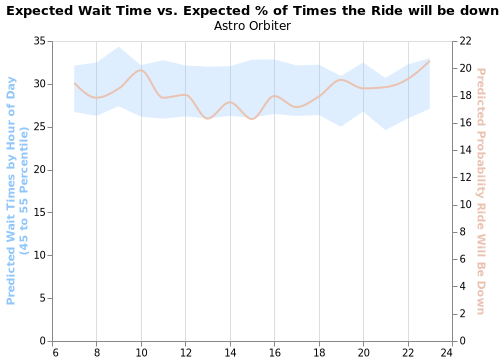

In [44]:
astro_orbiter = rideResults[0].visualize_wait_times(.45, .55)
save(astro_orbiter, "../reports/figures/AstroOrbiterWaitTimes.png")
astro_orbiter

### Big Thunder Mountain Railroad


This ride is predicted to be down significantly less after 8PM with wait times remaining fairly consistent. Wait times do hit a noticeable low around lunch time so we'd recommend either hitting BTM around noon or after dark.

The wait times are highly correlated with capacity metrics & whether there is a show/parade at Magic Kingdom.

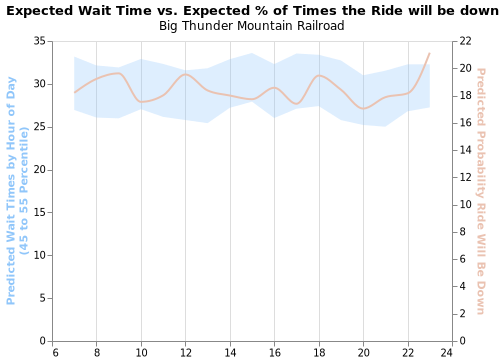

In [45]:
btm = rideResults[1].visualize_wait_times(.45, .55)
save(btm, "../reports/figures/BigThunderMountainWaitTimes.png")
btm

### Buzz Lightyear's Space Ranger Spin

The wait times for this ride are fairly consistent. Fit it in anytime you have some free time in your day!

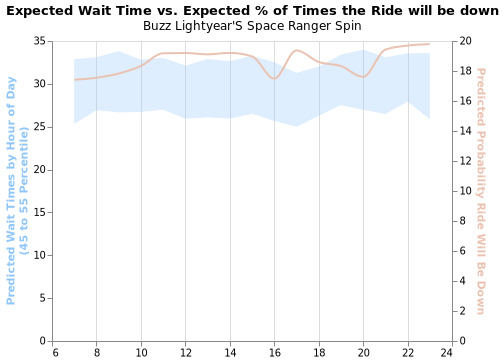

In [46]:
buzz = rideResults[2].visualize_wait_times(.45, .55)
save(buzz, "../reports/figures/BuzzLightyearSpaceRangerSpin.png")
buzz

### Dumbo the Flying Elephant

The wait times for this ride are fairly consistent. Fit it in anytime you have some free time in your day!

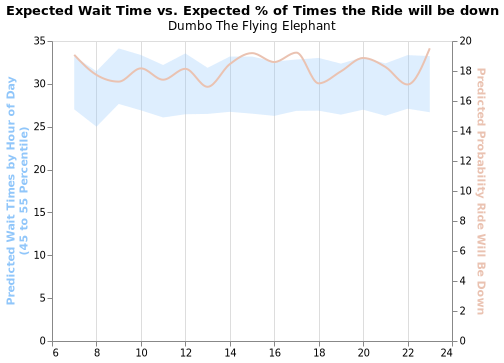

In [48]:
dumbo = rideResults[3].visualize_wait_times(.45, .55)
save(dumbo, "../reports/figures/DumboWaitTimes.png")
dumbo

### Haunted Mansion

Haunted mansion wait times and probability of being down drop around 3PM. This is a great time to hop on quickly!

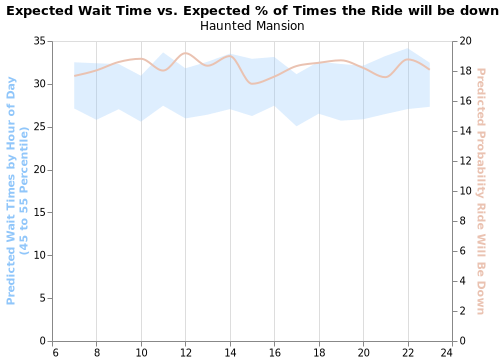

In [49]:
haunted_mansion = rideResults[4].visualize_wait_times(.45, .55)
save(haunted_mansion, "../reports/figures/HauntedMansionWaitTimes.png")
haunted_mansion

### It's a Small World

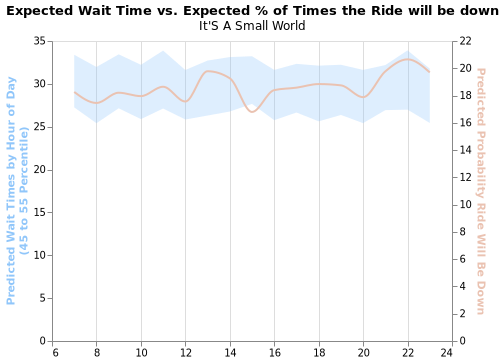

In [50]:
small_world = rideResults[5].visualize_wait_times(.45, .55)
save(small_world, "../reports/figures/ItsaSmallWorldWaitTimes.png")
small_world

### Jungle Cruise

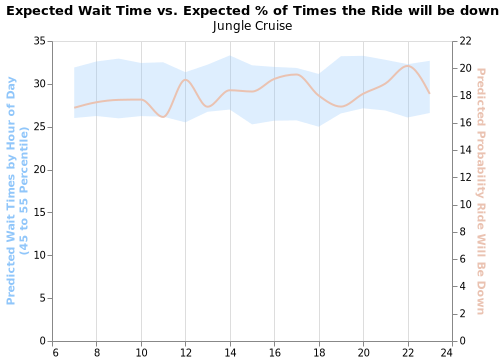

In [51]:
jungle_cruise = rideResults[6].visualize_wait_times(.45, .55)
save(jungle_cruise, "../reports/figures/JungleCruiseWaitTimes.png")
jungle_cruise

### Mad Tea Party

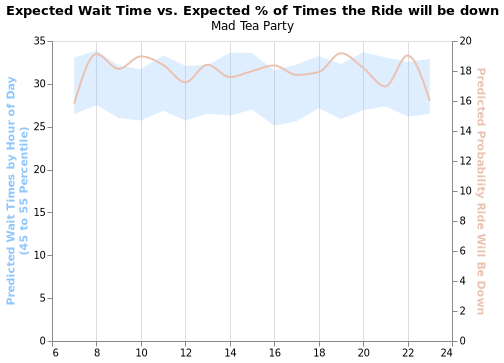

In [52]:
mad_tea_party = rideResults[7].visualize_wait_times(.45, .55)
save(mad_tea_party, "../reports/figures/MadTeamPartyWaitTimes.png")
mad_tea_party

### Peter Pan

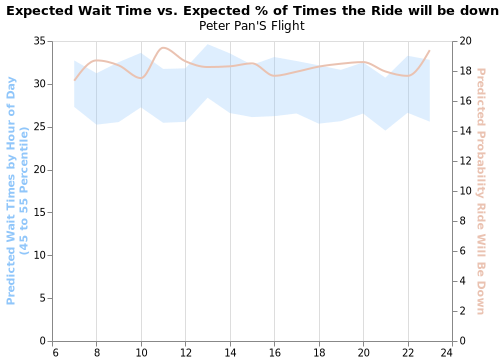

In [53]:
peter_pan = rideResults[8].visualize_wait_times(.45, .55)
save(peter_pan, "../reports/figures/PeterPanWaitTimes.png")
peter_pan

### Pirates of the Caribbean

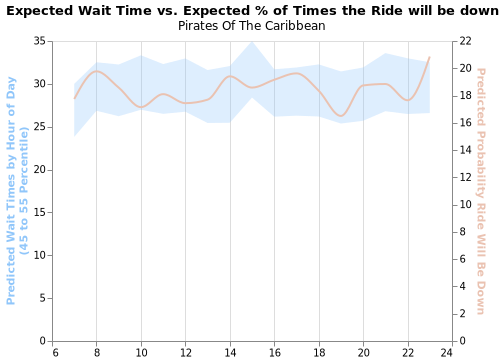

In [54]:
pirates = rideResults[9].visualize_wait_times(.45, .55)
save(pirates, "../reports/figures/PiratesWaitTimes.png")
pirates

### Prince Charming's Regal Carrousel


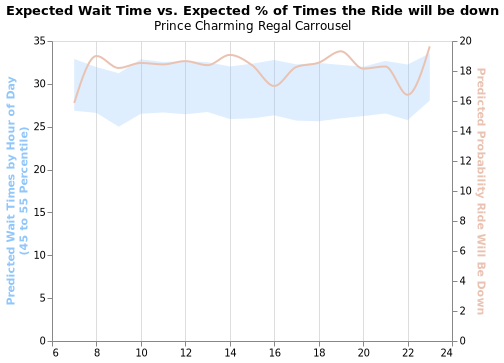

In [55]:
carousel = rideResults[10].visualize_wait_times(.45, .55)
save(carousel, "../reports/figures/CarouselWaitTimes.png")
carousel

### Seven Dwarfs' Mine Train

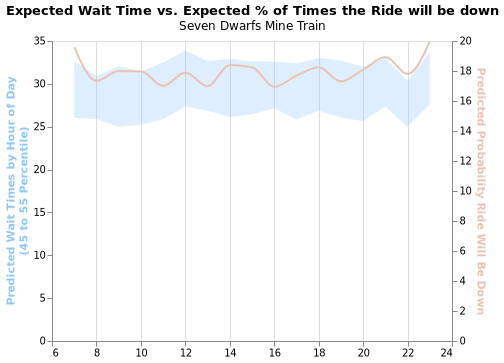

In [56]:
seven_dwarfs = rideResults[11].visualize_wait_times(.45, .55)
save(seven_dwarfs, "../reports/figures/7DwarfsWaitTimes.png")
seven_dwarfs

### Space Mountain

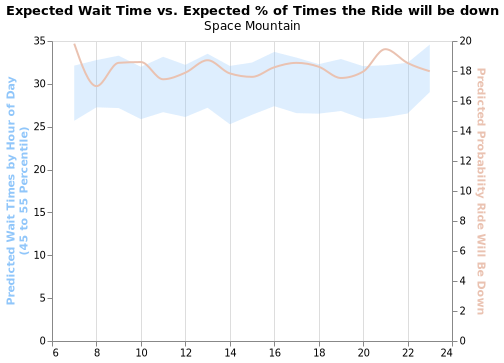

In [57]:
space_mtn = rideResults[12].visualize_wait_times(.45, .55)
save(space_mtn, "../reports/figures/SpaceMountainWaitTimes.png")
space_mtn

### Splash Mountain

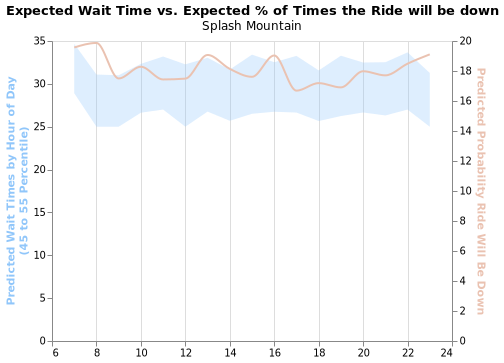

In [58]:
splash_mtn = rideResults[13].visualize_wait_times(.45, .55)
save(splash_mtn, "../reports/figures/SplashMountainWaitTimes.png")
splash_mtn

### Barnstormer

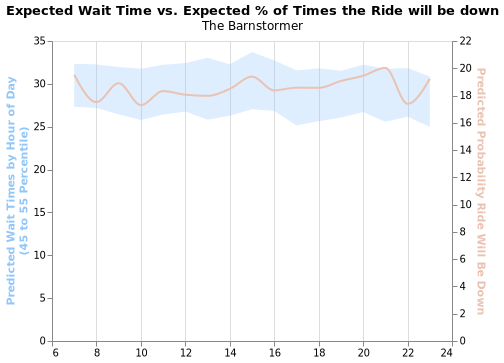

In [59]:
barnstormer = rideResults[14].visualize_wait_times(.45, .55)
save(barnstormer, "../reports/figures/BarnstormerWaitTimes.png")
barnstormer

### Magic Carpets of Aladdin

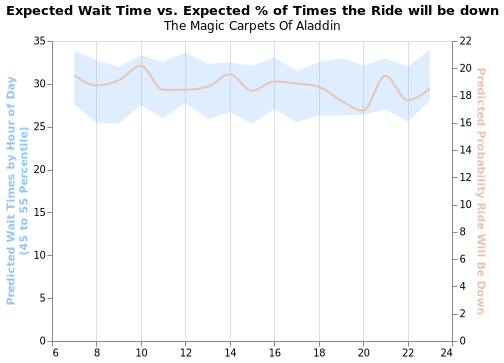

In [60]:
aladdin = rideResults[15].visualize_wait_times(.45, .55)
save(aladdin, "../reports/figures/AladdinWaitTimes.png")
aladdin

### Many Adventures of Winnie the Pooh

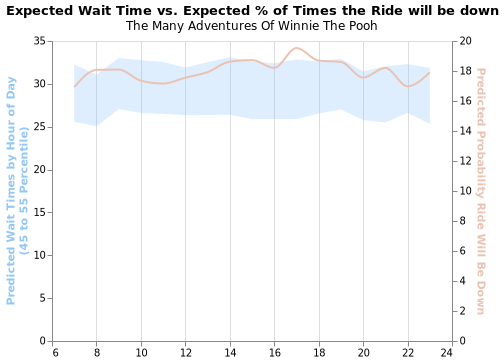

In [61]:
pooh = rideResults[16].visualize_wait_times(.45, .55)
save(pooh, "../reports/figures/WinnieThePoohWaitTimes.png")
pooh

### Tomorrowland Speedway

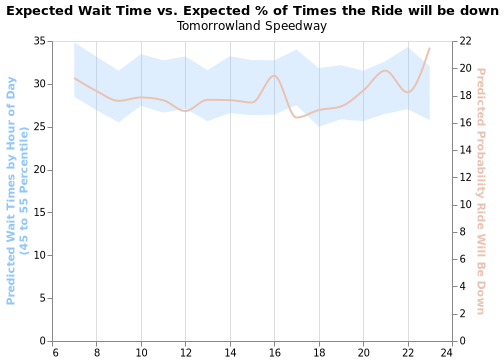

In [62]:
speedway = rideResults[17].visualize_wait_times(.45, .55)
save(speedway, "../reports/figures/TomorrowlandSpeedwayWaitTimes.png")
speedway

### People Mover

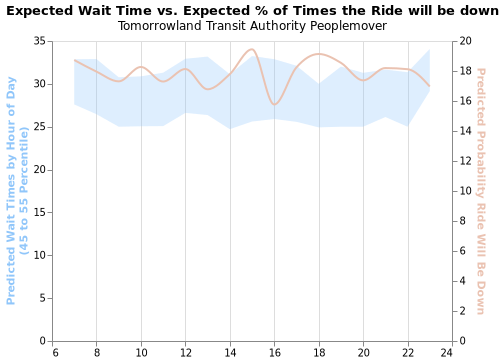

In [63]:
people_mover = rideResults[18].visualize_wait_times(.45, .55)
save(people_mover, "../reports/figures/PeopleMoverWaitTimes.png")
people_mover

### Carousel of Progress

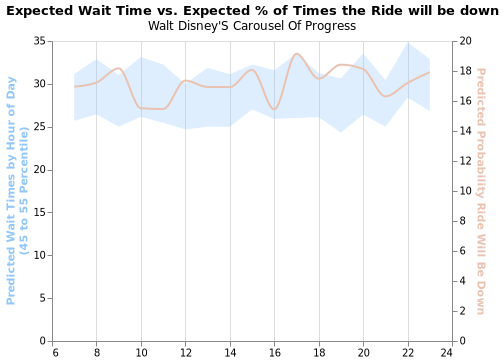

In [64]:
carousel_of_progress = rideResults[19].visualize_wait_times(.45, .55)
save(carousel_of_progress, "../reports/figures/CarouselofProgressWaitTimes.png")
carousel_of_progress